In [2]:
import torch
from transformer_lens import HookedTransformer
import numpy as np

# Load Dictionaries

In [3]:
from torch import nn
class AutoEncoder(nn.Module):
    def __init__(self, activation_size, n_dict_components, t_type=torch.float16):
        super(AutoEncoder, self).__init__()
        # create decoder using float16 to save memory
        self.decoder = nn.Linear(n_dict_components, activation_size, bias=False)
        # Initialize the decoder weights orthogonally
        nn.init.orthogonal_(self.decoder.weight)
        self.decoder = self.decoder.to(t_type)

        self.encoder = nn.Sequential(
            nn.Linear(activation_size, n_dict_components).to(t_type),
            nn.ReLU()
        )
        
    def forward(self, x):
        c = self.encoder(x)
        # Apply unit norm constraint to the decoder weights
        self.decoder.weight.data = nn.functional.normalize(self.decoder.weight.data, dim=0)
    
        x_hat = self.decoder(c)
        return x_hat, c
    
    @property
    def device(self):
        return next(self.parameters()).device
    

import pickle

filename = r'/root/sparse_coding/auto_encoders.pkl'

# Load the pickle file
with open(filename, 'rb') as file:
    autoencoders = pickle.load(file)

In [4]:
dictionaries = [autoencoder.decoder.weight.data.T for autoencoder in autoencoders[0]]

In [5]:
for d in dictionaries:
    print(d.shape)

torch.Size([2048, 2048])
torch.Size([4096, 2048])
torch.Size([8192, 2048])
torch.Size([16384, 2048])
torch.Size([32768, 2048])


In [6]:
smaller_dict, larger_dict = dictionaries[0], dictionaries[1]
smaller_auto_encoder, larger_auto_encoder = autoencoders[0][0], autoencoders[0][1]

# MCS

In [7]:
#Dictionary Comparison
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
smaller_dict_features, _ = smaller_dict.shape
larger_dict_features, _ = larger_dict.shape
larger_dict = larger_dict.to(device)
# Hungary algorithm
from scipy.optimize import linear_sum_assignment
# Calculate all cosine similarities and store in a 2D array
cos_sims = np.zeros((smaller_dict_features, larger_dict_features))
for idx, vector in enumerate(smaller_dict):
    cos_sims[idx] = torch.nn.functional.cosine_similarity(vector.to(device), larger_dict, dim=1).cpu().numpy()
# Convert to a minimization problem
cos_sims = 1 - cos_sims
# Use the Hungarian algorithm to solve the assignment problem
row_ind, col_ind = linear_sum_assignment(cos_sims)
# Retrieve the max cosine similarities and corresponding indices
max_cosine_similarities = 1 - cos_sims[row_ind, col_ind]

print(max_cosine_similarities)

[0.93541533 0.20955059 0.90894008 ... 0.08109202 0.05759869 0.0980377 ]


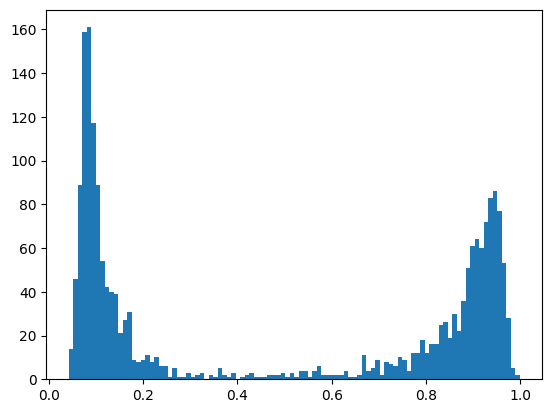

In [8]:
# Get the indices of the max cosine similarities in descending order
max_indices = np.argsort(max_cosine_similarities)[::-1]
max_cosine_similarities[max_indices][:20]
(max_cosine_similarities > .9).sum()
# Plot histogram of max_cosine_similarities
import matplotlib.pyplot as plt
plt.hist(max_cosine_similarities, bins=100)
plt.show()

# Model activations & Dictionary Activations

In [9]:
# Load in the Pythia model w/ transformer lens
model_name = "EleutherAI/pythia-70m-deduped"
model = HookedTransformer.from_pretrained(model_name, device=device)

Using pad_token, but it is not set yet.


Loaded pretrained model EleutherAI/pythia-70m-deduped into HookedTransformer


In [10]:
# Downnload dataset
from datasets import Dataset, load_dataset
dataset_name = "NeelNanda/pile-10k"
token_amount=25
dataset = load_dataset(dataset_name, split="train").map(
    lambda x: model.tokenizer(x['text']),
    batched=True,
).filter(
    lambda x: len(x['input_ids']) > token_amount
).map(
    lambda x: {'input_ids': x['input_ids'][:token_amount]}
)

Found cached dataset parquet (/root/.cache/huggingface/datasets/NeelNanda___parquet/NeelNanda--pile-10k-72f566e9f7c464ab/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
Loading cached processed dataset at /root/.cache/huggingface/datasets/NeelNanda___parquet/NeelNanda--pile-10k-72f566e9f7c464ab/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-27e019ffdbbb8e00.arrow


Filter:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/9938 [00:00<?, ? examples/s]

In [11]:
# Now we can use the model to get the activations
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from einops import rearrange
neurons = model.W_in.shape[-1]
datapoints = dataset.num_rows
batch_size = 64
layer = 2
neuron_activations = torch.zeros((datapoints*token_amount, neurons))
dictionary_activations = torch.zeros((datapoints*token_amount, smaller_dict_features))
smaller_auto_encoder = smaller_auto_encoder.to(device)

with torch.no_grad(), dataset.formatted_as("pt"):
    dl = DataLoader(dataset["input_ids"], batch_size=batch_size)
    for i, batch in enumerate(tqdm(dl)):
        _, cache = model.run_with_cache(batch.to(device))
        batched_neuron_activations = rearrange(cache[f"blocks.{layer}.mlp.hook_post"], "b s n -> (b s) n" )
        neuron_activations[i*batch_size*token_amount:(i+1)*batch_size*token_amount,:] = batched_neuron_activations
        reconstruction, batched_dictionary_activations = smaller_auto_encoder(batched_neuron_activations)
        dictionary_activations[i*batch_size*token_amount:(i+1)*batch_size*token_amount,:] = batched_dictionary_activations

  0%|          | 0/156 [00:00<?, ?it/s]

## Neuron Sparsity per Feature by Activations

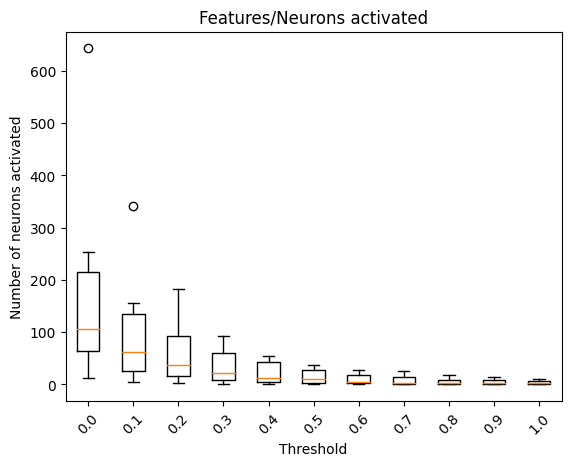

In [12]:
# Find corresponding neurons activations between pythia & autoencoder
# Get the activations for the best dict features
thresholds = [round(0.1*x,1) for x in range(11)]
all_activated_neurons = []
for threshold in thresholds:
    current_activated_neurons = []
    for x in range(10):
        best_feature = max_indices[x]
        best_feature_activations = dictionary_activations[:, best_feature]
        # Sort the features by activation, get the indices
        nonzero_indices = torch.argsort(best_feature_activations, descending=True)
        sorted_indices = nonzero_indices[:10]
        t = (neuron_activations[sorted_indices, :] > threshold)
        # ( And across the first dim)
        t = t.all(dim=0)
        neurons_activated = t.sum()
        current_activated_neurons.append(neurons_activated)
        # print(f"Feature {x} is active for {t.sum()} neurons")
    all_activated_neurons.append(current_activated_neurons)
# Plot boxplot w/ plotly

plt.boxplot(all_activated_neurons, labels=thresholds)
plt.xticks(rotation=45)
plt.xlabel("Threshold")
plt.ylabel("Number of neurons activated")
plt.title("Features/Neurons activated")
# plt.ylim(0, 50)
plt.show()

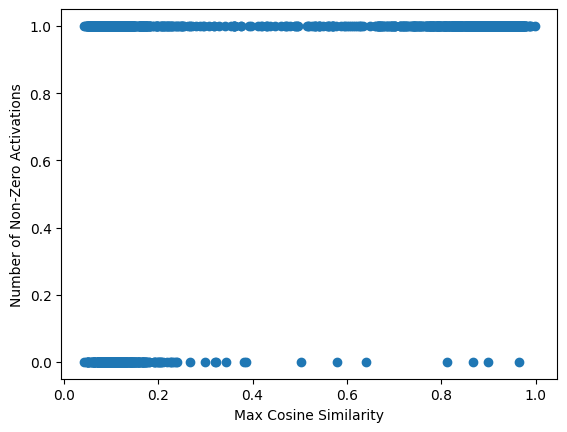

In [13]:
# Find number of non-zero activations for each feature in the dictionary
nonzero_activations = dictionary_activations.count_nonzero(dim=0)
# clip to 1
nonzero_activations = nonzero_activations.clamp(max=1)
# plot against the max cosine similarities
# plt.hist(nonzero_activations.cpu().numpy(), bins=100)
plt.scatter(max_cosine_similarities, nonzero_activations.cpu().numpy())
# x-axis is the max cosine similarity
# y-axis is the number of non-zero activations
# now setting x-axis
plt.xlabel("Max Cosine Similarity")
plt.ylabel("Number of Non-Zero Activations")
plt.show()

# Feature Activation Analysis

In [14]:
from circuitsvis.activations import text_neuron_activations
# Get the activations for the best dict features
def get_feature_datapoints(feature_index, dictionary_activations, dataset, k=10, setting="max"):
    best_feature_activations = dictionary_activations[:, feature_index]
    # Sort the features by activation, get the indices
    if setting=="max":
        found_indices = torch.argsort(best_feature_activations, descending=True)[:k]
    elif setting=="uniform":
        sorted_values, sorted_indices = torch.sort(best_feature_activations, descending=True)
        nonzero_indices = torch.nonzero(sorted_values)[:, 0]
        uniform_indices = torch.linspace(0, nonzero_indices.shape[0]-1, k).round().long()
        found_indices = sorted_indices[nonzero_indices][uniform_indices]
        # Append the last indice of sorted_indices to found_indices
        found_indices = torch.cat((found_indices, torch.tensor([sorted_indices[-1]])))
    else: # random
        # get nonzero indices
        nonzero_indices = torch.nonzero(best_feature_activations)[:, 0]
        # shuffle
        shuffled_indices = nonzero_indices[torch.randperm(nonzero_indices.shape[0])]
        found_indices = shuffled_indices[:k]
    datapoint_indices =[np.unravel_index(i, (datapoints, token_amount)) for i in found_indices]
    text_list = []
    full_text = []
    token_list = []
    full_token_list = []
    for md, s_ind in datapoint_indices:
        md = int(md)
        s_ind = int(s_ind)
        full_tok = torch.tensor(dataset[md]["input_ids"])
        full_text.append(model.tokenizer.decode(full_tok))
        tok = dataset[md]["input_ids"][:s_ind+1]
        text = model.tokenizer.decode(tok)
        text_list.append(text)
        token_list.append(tok)
        full_token_list.append(full_tok)
    return text_list, full_text, token_list, full_token_list

def get_neuron_activation(token, feature, model):
    with torch.no_grad():
        _, cache = model.run_with_cache(token.to(model.cfg.device))
        neuron_act_batch = cache[f"blocks.{layer}.mlp.hook_post"]
        _, act = smaller_auto_encoder(neuron_act_batch)
    return act[0, :, feature].tolist()

def ablate_text(text, feature, model, setting="plot"):
    if isinstance(text, str):
        text = [text]
    display_text_list = []
    activation_list = []
    for t in text:
        # Convert text into tokens
        if isinstance(t, str): # If the text is a list of tokens
            split_text = model.to_str_tokens(t, prepend_bos=False)
            tokens = model.to_tokens(t, prepend_bos=False)
        else: # t equals tokens
            tokens = t
            split_text = model.to_str_tokens(t, prepend_bos=False)
        seq_size = tokens.shape[1]
        if(seq_size == 1): # If the text is a single token, we can't ablate it
            continue
        original = get_neuron_activation(tokens, feature, model)[-1]
        changed_activations = torch.zeros(seq_size, device=device).cpu()
        for i in range(seq_size):
            # Remove the i'th token from the input
            ablated_tokens = torch.cat((tokens[:,:i], tokens[:,i+1:]), dim=1)
            changed_activations[i] += get_neuron_activation(ablated_tokens, feature, model)[-1]
        changed_activations -= original
        display_text_list += [x.replace('\n', '\\newline') for x in split_text] + ["\n"]
        activation_list += changed_activations.tolist() + [0.0]
    activation_list = torch.tensor(activation_list).reshape(-1,1,1)
    if setting == "plot":
        return text_neuron_activations(tokens=display_text_list, activations=activation_list)
    else:
        return display_text_list, activation_list
def visualize_text(text, feature, model, setting="plot"):
    if isinstance(text, str):
        text = [text]
    display_text_list = []
    act_list = []
    for t in text:
        if isinstance(t, str): # If the text is a list of tokens
            split_text = model.to_str_tokens(t, prepend_bos=False)
            token = model.to_tokens(t, prepend_bos=False)
        else: # t are tokens
            token = t
            split_text = model.to_str_tokens(t, prepend_bos=False)
        display_text_list += [x.replace('\n', '\\newline') for x in split_text] + ["\n"]
        act_list += get_neuron_activation(token, feature, model) + [0.0]
    act_list = torch.tensor(act_list).reshape(-1,1,1)
    return text_neuron_activations(tokens=display_text_list, activations=act_list)


In [15]:
# k=10
# best_feature_activations = get_feature_datapoints(best_feature, dictionary_activations, dataset, setting="uniform")
# sorted_values, sorted_indices = torch.sort(best_feature_activations, descending=True)
# nonzero_indices = torch.nonzero(sorted_values)[:, 0]

# uniform_indices = torch.linspace(0, nonzero_indices.shape[0]-1, k).round().long()
# found_indices = sorted_indices[nonzero_indices][uniform_indices]
# # Append the last indice of sorted_indices to found_indices
# found_indices = torch.cat((found_indices, torch.tensor([sorted_indices[-1]])))

In [16]:
# sorted_indices, found_indices

In [17]:
# Ablate the feature direction of the tokens
# token_list is a list of tokens, convert to tensor of shape (batch_size, seq_len)
from einops import rearrange
def ablate_feature_direction(tokens, feature, model, autoencoder):
    def mlp_ablation_hook(value, hook):
        # Rearrange to fit autoencoder
        int_val = rearrange(value, 'b s h -> (b s) h')

        # Run through the autoencoder
        _, act = autoencoder(int_val)
        feature_to_ablate = feature # TODO: bring this out of the function

        # Subtract value with feature direction*act_of_feature
        feature_direction = torch.outer(act[:, feature_to_ablate], autoencoder.decoder.weight[:, feature_to_ablate])
        batch, seq_len, hidden_size = value.shape
        feature_direction = rearrange(feature_direction, '(b s) h -> b s h', b=batch, s=seq_len)
        value -= feature_direction
        return value
    # def mlp_ablation_hook(value, hook):
    #     # Rearrange to fit autoencoder
    #     int_val = rearrange(value, 'b s h -> (b s) h')

    #     # Run through the autoencoder
    #     _, act = autoencoder(int_val)
    #     feature_to_ablate = feature # TODO: bring this out of the function

    #     # Subtract value with feature direction*act_of_feature
    #     feature_direction = torch.outer(act[:, feature_to_ablate], autoencoder.decoder.weight[:, feature_to_ablate])
    #     batch, seq_len, hidden_size = value.shape
    #     feature_direction = rearrange(feature_direction, '(b s) h -> b s h', b=batch, s=seq_len)
    #     value -= feature_direction
    #     return value

    return model.run_with_hooks(tokens, 
        fwd_hooks=[(
            f"blocks.{layer}.mlp.hook_post", 
            mlp_ablation_hook
            )]
        )
def visualize_logit_diff(text, features=None, setting="true_tokens", verbose=False):
    text = full_text
    features = best_feature

    if features==None:
        features = torch.tensor([best_feature])
    if isinstance(features, int):
        features = torch.tensor([features])
    if isinstance(features, list):
        features = torch.tensor(features)
    if isinstance(text, str):
        text = [text]
    text_list = []
    logit_list = []
    for t in text:
        tokens = model.to_tokens(t, prepend_bos=False)
        with torch.no_grad():
            original_logits = model(tokens).log_softmax(-1).cpu()
            ablated_logits = ablate_feature_direction(tokens, features, model, smaller_auto_encoder).log_softmax(-1).cpu()
        diff_logits = ablated_logits  - original_logits# ablated > original -> negative diff
        tokens = tokens.cpu()
        if setting == "true_tokens":
            split_text = model.to_str_tokens(t, prepend_bos=False)
            gather_tokens = rearrange(tokens[:,1:], "b s -> b s 1") # TODO: verify this is correct
            # Gather the logits for the true tokens
            diff = rearrange(diff_logits[:, :-1].gather(-1,gather_tokens), "b s n -> (b s n)")
        elif setting == "max":
            # Negate the diff_logits to see which tokens have the largest effect on the neuron
            val, ind = (-1*diff_logits).max(-1)
            diff = rearrange(val[:, :-1], "b s -> (b s)")
            diff*= -1 # Negate the values gathered
            split_text = model.to_str_tokens(ind, prepend_bos=False)
            gather_tokens = rearrange(ind[:,1:], "1 s -> 1 s 1")
        split_text = split_text[1:] # Remove the first token since we're not predicting it
        if(verbose):
            text_list += [x.replace('\n', '\\newline') for x in split_text] + ["\n"]
            text_list += [x.replace('\n', '\\newline') for x in split_text] + ["\n"]
            orig = rearrange(original_logits[:, :-1].gather(-1, gather_tokens), "b s n -> (b s n)")
            ablated = rearrange(ablated_logits[:, :-1].gather(-1, gather_tokens), "b s n -> (b s n)")
            logit_list += orig.tolist() + [0.0]
            logit_list += ablated.tolist() + [0.0]
        text_list += [x.replace('\n', '\\newline') for x in split_text] + ["\n"]
        logit_list += diff.tolist() + [0.0]
    logit_list = torch.tensor(logit_list).reshape(-1,1,1)
    if verbose:
        print(f"Max & Min logit-diff: {logit_list.max().item():.2f} & {logit_list.min().item():.2f}")
    return text_neuron_activations(tokens=text_list, activations=logit_list)

In [18]:
max_mcs= True
if max_mcs:
    N = 6
    best_feature = max_indices[N]
else: # by threshold
    threshold = 0.3
    error = 0.01
    max_cosine_similarities[max_indices]
    threshold_indices = np.nonzero((max_cosine_similarities[max_indices] > threshold-error) & (max_cosine_similarities[max_indices] < threshold+error))
    N = threshold_indices[0][0]
    best_feature = max_indices[N]

print(f"Max feature index: {N}")
print(f"MCS: {max_cosine_similarities[best_feature]}")
text_list, full_text, token_list, full_token_list = get_feature_datapoints(best_feature, dictionary_activations, dataset, setting="max")
visualize_text(text_list, best_feature, model, setting="plot")

Max feature index: 6
MCS: 0.9796159267425537


In [19]:
ablate_text(text_list, best_feature, model, setting="plot")

In [20]:
visualize_logit_diff(full_text, best_feature)

In [21]:
# Instead of top-k examples, just random samples from non-zero values
text_list, full_text, _, _ = get_feature_datapoints(best_feature, dictionary_activations, dataset, setting="uniform", k=10)
visualize_text(text_list, best_feature, model, setting="plot")

In [22]:
# Specific examples

#f5
text_list = [
    ' I do.""',
    'I do""',
    'I do?""',
    "I do''"

]
#f52
text_list = [
    " $",
    " for $",
    " integral $",
    " for integral $",
    " sold $",
    " hey $",
    " 1 $",
    " sold for $",
    " for all $",
    " sold for all $",
    " profit for all $",
    " \nfor all $",
    " {] for all $",
]
#f3?
text_list = [
    "www",
    " www.",
    " vol. www.",
    # " go to the www.",
    " vol www.",
    "://aaa"
    " http://aaa",
]
#f4
text_list = [
    "' '",
    '" "',
    '?" "',
    '." "',
    '." \'',
    '." d',
    '." }',
    '." 1',
    ' "',
]
#f5
text_list = [
    "-type",
    " silica nanoparticles multidrug resistance",
    " type-type-type",
]
#f6
text_list = [
    "*n",
    "*j",
    "*5",
    "xn",
    "4n",
    "*]",
]

visualize_text(text_list, best_feature, model, setting="plot")

In [63]:
# Verify $ feature is math related & anti-money
# minimal_activating_example = " for all $" # f52 (GOOD)
# minimal_activating_example = ". www." # f3 (???)
# minimal_activating_example = ' "' # f4 (GOOD)
# minimal_activating_example = 'type' # f5 (BAD/ misleading)
# minimal_activating_example = '-type' # f5 (BAD/ misleading)
# minimal_activating_example = '*' # f6 (GOOD)
# minimal_activating_example = 'n' # f6 (GOOD)
minimal_activating_example = ' carl' # f6 (GOOD)

def prepend_all_tokens_and_get_feature_activation(model, minimal_activating_example, feature, setting="prepend"):
    tokens = model.to_tokens(minimal_activating_example, prepend_bos=False)

    # Run through every number up to vocab size
    vocab_size = model.cfg.d_vocab
    batch_size = 256*4  # Define your desired batch size

    dollar_feature_activations = torch.zeros(vocab_size)
    for start in range(0, vocab_size, batch_size):
        end = min(start + batch_size, vocab_size)

        token_prep = torch.arange(start, end).to(device)
        token_prep = token_prep.unsqueeze(1)  # Add a dimension for concatenation

        # 1. Prepend to the tokens
        if setting == "prepend":
            tokens_catted = torch.cat((token_prep, tokens.repeat(end - start, 1)), dim=1)
        elif setting == "append":
            tokens_catted = torch.cat((tokens.repeat(end - start, 1), token_prep), dim=1)
        else:
            raise ValueError(f"Unknown setting: {setting}")

        # 2. Run through the model
        with torch.no_grad():
            _, cache = model.run_with_cache(tokens_catted.to(device))
            neuron_act_batch = cache[f"blocks.{layer}.mlp.hook_post"]
            _, act = smaller_auto_encoder(neuron_act_batch)

        # 3. Get the feature
        dollar_feature_activations[start:end] = act[:, -1, feature].cpu().squeeze()

    k = 20
    k_increasing_val, k_increasing_ind = dollar_feature_activations.topk(k)
    k_decreasing_val, k_decreasing_ind = dollar_feature_activations.topk(k, largest=False)
    if(setting == "prepend"):
        print(f"[token]{minimal_activating_example}")
    elif(setting == "append"):
        print(f"{minimal_activating_example}[token]")
    else:
        raise ValueError(f"Unknown setting: {setting}")
    # Print indices converted to tokens
    print(f"Top-{k} increasing: {model.to_str_tokens(k_increasing_ind)}")
    # Print values
    print(f"Top-{k} increasing: {[f'{val:.2f}' for val in k_increasing_val]}")
    print(f"Top-{k} decreasing: {model.to_str_tokens(k_decreasing_ind)}")
    print(f"Top-{k} decreasing: {[f'{val:.2f}' for val in k_decreasing_val]}")

# F6
prepend_all_tokens_and_get_feature_activation(model, "*", best_feature, setting="append")
# prepend_all_tokens_and_get_feature_activation(model, "*", best_feature, setting="prepend")
# prepend_all_tokens_and_get_feature_activation(model, "n", best_feature, setting="append")
# prepend_all_tokens_and_get_feature_activation(model, "n", best_feature, setting="prepend")
# prepend_all_tokens_and_get_feature_activation(model, " Alice", best_feature, setting="append")
# prepend_all_tokens_and_get_feature_activation(model, " Alice", best_feature, setting="prepend")
# prepend_all_tokens_and_get_feature_activation(model, "*", best_feature, setting="d")

*[token]
Top-20 increasing: ['w', 'h', 'v', 't', 'd', 'b', 'k', 'n', 'm', 'f', 'r', 'p', 'q', 'o', 's', 'l', 'u', 'e', 'i', 'c']
Top-20 increasing: ['7.68', '7.61', '7.35', '7.21', '7.20', '7.19', '6.95', '6.84', '6.74', '6.73', '6.63', '6.43', '6.36', '6.28', '6.28', '6.28', '6.23', '6.22', '6.18', '6.16']
Top-20 decreasing: ['"', ')', '<|endoftext|>', '&', '+', ';', '(', '?', '*', '$', '.', ',', ':', "'", '>', '#', '@', '<', '!', '%']
Top-20 decreasing: ['0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00']


In [ ]:
token_prep.unsqueeze(0).shape, tokens.shape

(torch.Size([1, 1]), torch.Size([1, 3]))

In [ ]:
model.cfg.d_vocab

50304

Threshold: 0.0, Neurons activated: 94
Threshold: 0.1, Neurons activated: 39
Threshold: 0.2, Neurons activated: 22
Threshold: 0.3, Neurons activated: 10
Threshold: 0.4, Neurons activated: 6
Threshold: 0.5, Neurons activated: 3
Threshold: 0.6, Neurons activated: 0
Threshold: 0.7, Neurons activated: 0
Threshold: 0.8, Neurons activated: 0
Threshold: 0.9, Neurons activated: 0
Threshold: 1.0, Neurons activated: 0


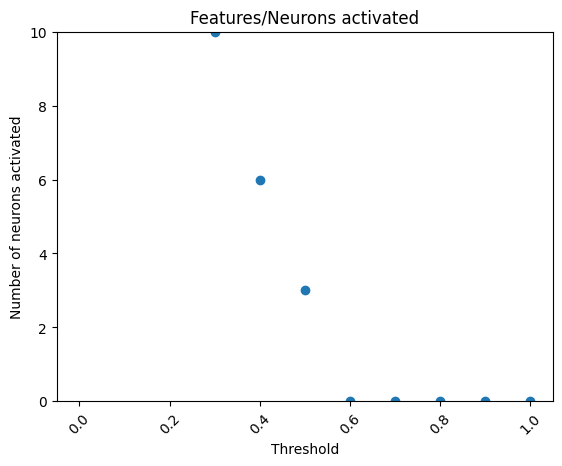

In [ ]:
# Neurons that fire for this feature
# Find corresponding neurons activations between pythia & autoencoder
# Get the activations for the best dict features
len_threshold = 11
thresholds = [round(0.1*x,1) for x in range(len_threshold)]
current_activated_neurons = np.zeros(len_threshold)
for idx, threshold in enumerate(thresholds):
    best_feature_activations = dictionary_activations[:, best_feature]
    # Sort the features by activation, get the indices
    nonzero_indices = torch.argsort(best_feature_activations, descending=True)
    sorted_indices = nonzero_indices[:10]
    t = (neuron_activations[sorted_indices, :] > threshold)
    # And across the first dim)
    t = t.all(dim=0)
    neurons_activated = t.sum()
    current_activated_neurons[idx] = neurons_activated
    print(f"Threshold: {threshold}, Neurons activated: {neurons_activated}")
# Plot boxplot w/ plotly
plt.scatter(thresholds, current_activated_neurons)
plt.xticks(rotation=45)
plt.xlabel("Threshold")
plt.ylabel("Number of neurons activated")
plt.title("Features/Neurons activated")
plt.ylim(0, 10)
plt.show()

In [ ]:
# Logit lens
# Multiply feature direction by W_out[layer]
# Then by W_U
for n in range(10):
    best_feature = max_indices[n]
    with torch.no_grad():
        feature_direction = smaller_dict[best_feature].to(device)
        residual_direction = torch.matmul(feature_direction, model.W_out[layer]) # Add bias
        # residual_direction = model.ln_final(residual_direction)
        logits = torch.matmul(residual_direction, model.W_U).cpu()
    topk_values, topk_indices = torch.topk(logits, 10)
    top_text = model.to_str_tokens(topk_indices)
    print(f"Feature {n}: {top_text}")
# print(topk_values)

Feature 0: ['ocompat', 'lated', '��', 'liest', 'atically', '://', 'pired', 'ky', 'alin', '----']
Feature 1: ['soever', ' aside', ' sight', ' pigment', 'ably', ' forth', ' viewed', ' McKin', ' Cotton', 'pieces']
Feature 2: ['soever', 'mente', 'raction', 'zer', 'burn', 'lessly', 'eries', 'ce', 'zig', 'edly']
Feature 3: ['hood', 'edly', 'atsu', ' Field', ' teeth', 'EVER', ' sheets', 'uma', 'aster', 'ess']
Feature 4: ['ftware', ' difference', ' limits', '://', ' applicability', 'cludes', ' disadvantage', 'ffect', ' differences', ' inconvenience']
Feature 5: [' Funding', 'yer', 'ucc', ' Correspond', ' Wrote', 'hill', 'emit', ' Below', ' illustrating', 'zzi']
Feature 6: ['"}](#', 'iator', 'theless', 'confidence', ' doubt', 'red', ' contrast', 'ordo', 'íc', 'reement']
Feature 7: [' \n           ', '\n                                      ', '                                                                                                                                                         

In [ ]:
import circuitsvis
text = full_text
features = best_feature

if features==None:
    features = torch.tensor([best_feature])
if isinstance(features, int):
    features = torch.tensor([features])
if isinstance(features, list):
    features = torch.tensor(features)
if isinstance(text, str):
    text = [text]
text_list = []
logit_list = []
for t in text:
    tokens = model.to_tokens(t, prepend_bos=False)
    with torch.no_grad():
        original_logits = model(tokens).log_softmax(-1).cpu()
        ablated_logits = ablate_feature_direction(tokens, features, model, smaller_auto_encoder).log_softmax(-1).cpu()
    # diff_logits = ablated_logits  - original_logits# ablated > original -> negative diff
    diff_logits =   original_logits - ablated_logits# ablated > original -> negative diff
    tokens = tokens.cpu()
    split_text = model.to_str_tokens(t, prepend_bos=False)
    gather_tokens = rearrange(tokens[:,1:], "b s -> b s 1") # TODO: verify this is correct
    # Gather the logits for the true tokens
    true_log_probs = rearrange(diff_logits[:, :-1].gather(-1,gather_tokens), "b s n -> (b s n)")
    break
# Add an extra dim for the batch
diff_logits = diff_logits[0]
tokens = tokens[0]
print(diff_logits.shape, tokens.shape)
# circuitsvis.logits.token_log_probs(token_indices=tokens, top_k=10, log_probs=original_logits, to_string=model.to_single_str_token)
circuitsvis.logits.token_log_probs(token_indices=tokens, top_k=10, log_probs=diff_logits, to_string=model.to_single_str_token)
# circuitsvis.logits.token_log_probs(token_indices=tokens, top_k=10, log_probs=ablated_logits, to_string=model.to_single_str_token)

torch.Size([60, 50304]) torch.Size([60])


In [ ]:
circuitsvis.logits.token_log_probs(token_indices=)

TypeError: token_log_probs() missing 3 required positional arguments: 'token_indices', 'log_probs', and 'to_string'

In [ ]:
visualize_logit_diff(full_text, best_feature)

In [ ]:
ablate_text(text_list, best_feature, model, setting="plot")

In [ ]:
larger_auto_encoder.decoder.weight.shape

torch.Size([2048, 4096])

In [ ]:
features

1996

In [ ]:
features = 2
if isinstance(features, int):
    features = torch.tensor([features])

IndentationError: expected an indented block after 'if' statement on line 8 (2601719594.py, line 9)

In [ ]:
if True:
    pass

In [ ]:
logit_diff = original_logits.log_softmax(dim=-1) - ablated_logits.log_softmax(dim=-1)
# Gather the logit difference for the true label
predicted_logit_diff = logit_diff[:,:-1].gather(dim=-1, index=all_tokens[:,1:].unsqueeze(-1))
predicted_logit_diff = predicted_logit_diff.squeeze(-1)

torch.Size([10, 59])

In [ ]:
logit_diff[:, 1:].shape, all_tokens[:,:-1].shape

(torch.Size([10, 59, 50304]), torch.Size([10, 59]))

In [ ]:
# Find the feature direction of the first feature
dictionary_activations.shape

torch.Size([580380, 2048])

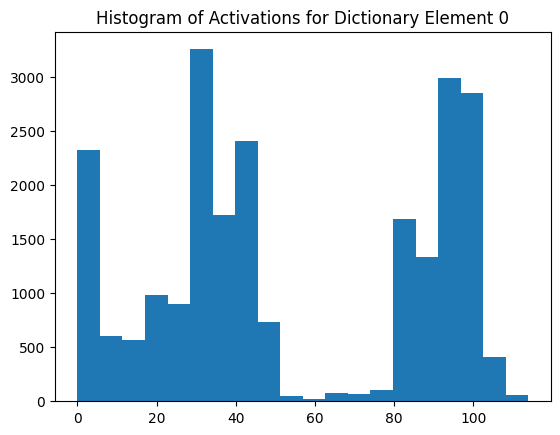

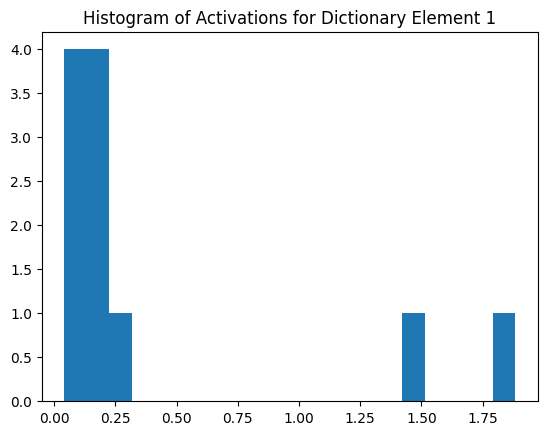

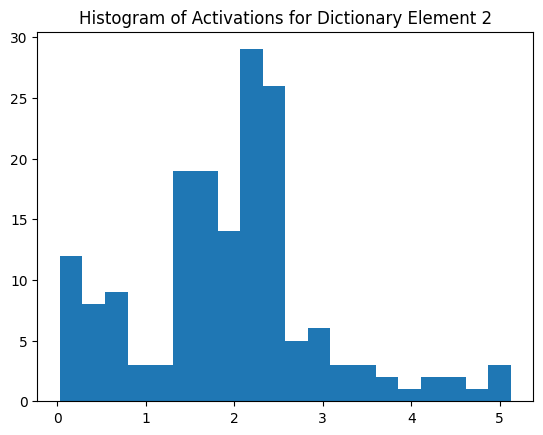

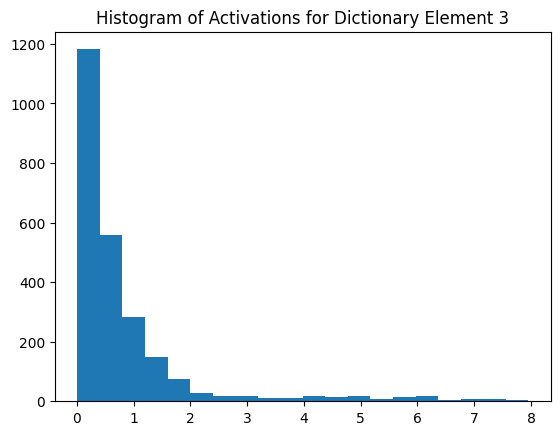

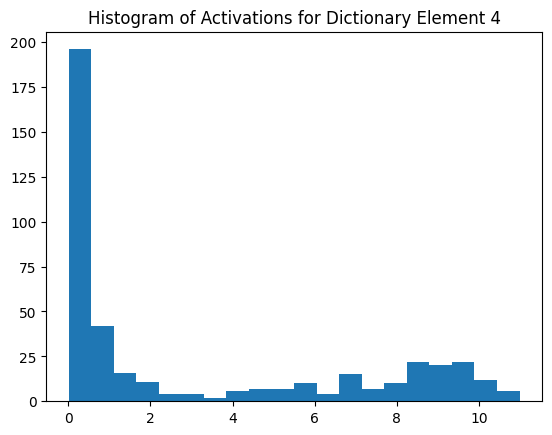

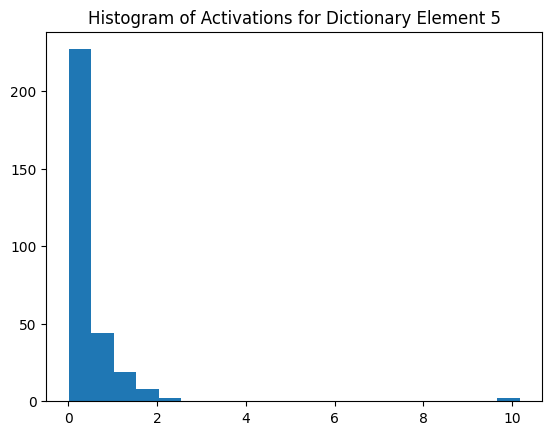

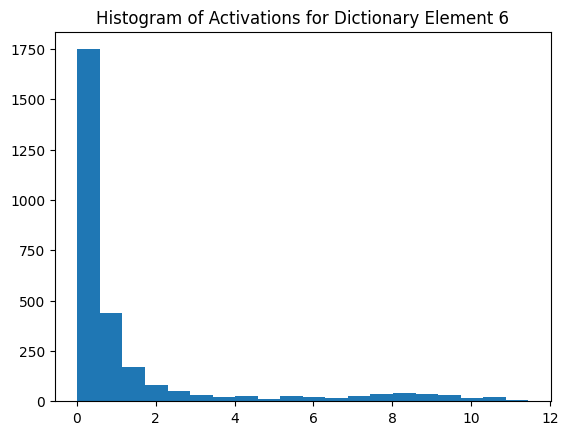

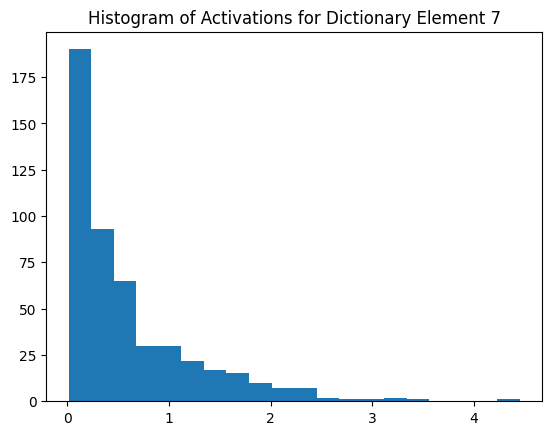

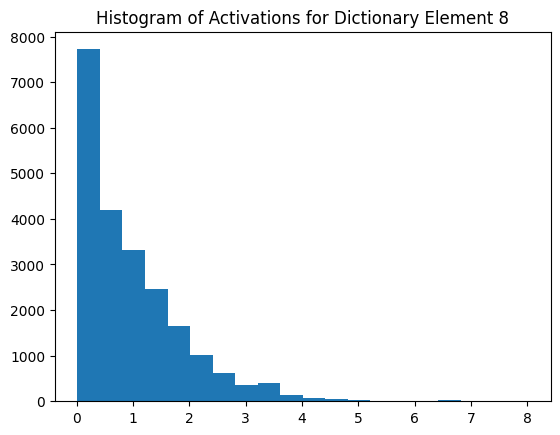

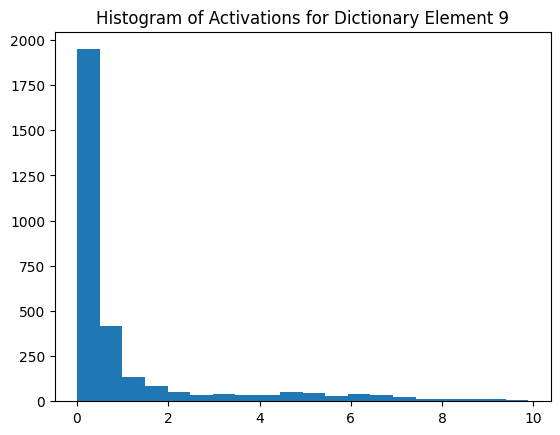

In [ ]:
#Plot a histogram
import matplotlib.pyplot as plt
for x in range(10):
    max_elements = (dictionary_activations[:, max_indices[x]]>0.01)
    plt.hist(dictionary_activations[max_elements, max_indices[x]], bins=20)
    plt.title('Histogram of Activations for Dictionary Element ' + str(x))
    plt.show()

In [ ]:
#Plot a histogram
import matplotlib.pyplot as plt
for x in range(10):
    print((dictionary_activations[:, max_indices[x]] > 0.0).sum().item())

23153
11
170
2500
433
315
2917
511
22561
3170


In [ ]:
dictionary_activations[:, max_indices[x]].shape

torch.Size([580380])